# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [8]:
# Mqke the notebook wider to visualize Spark outputs better
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [9]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import functions as F

from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer, VectorAssembler, Normalizer, \
    StandardScaler, PCA, StopWordsRemover, StringIndexer, VectorAssembler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [10]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# 1. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

**1.1. Load the dataset**

In [11]:
# Load the data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

**1.2. Look at the data**

In [12]:
# Get schema and sample of the data
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# How many rows in the dataset
user_log.count()

286500

In [14]:
# Show the first row
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [15]:
# Show the first 5 rows
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

**1.3. Get statistics on the numerical data**

In [16]:
# Get statistics for the numericalvalues
user_log.describe(["length", "ts"]).show()

+-------+-----------------+--------------------+
|summary|           length|                  ts|
+-------+-----------------+--------------------+
|  count|           228108|              286500|
|   mean|249.1171819778458|1.540956889810483...|
| stddev|99.23517921058361|1.5075439608226302E9|
|    min|          0.78322|       1538352117000|
|    max|       3024.66567|       1543799476000|
+-------+-----------------+--------------------+



**1.4. Handle missing values**

Let's check which columns have missing values.

In [17]:
null_df = user_log.select([F.count(F.when(F.isnan(i) | \
                                          (F.col(i) == '') | \
                                          F.col(i).isNull(), i)).alias(i) \
                                  for i in user_log.columns])

null_df.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



It looks like the sessionId column does not contain any missing values. Let's check the instances where the userId is null.

In [18]:
user_log.filter(user_log.userId == '').show(10)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

Check if there is a specific type of action that has missing userId.

In [19]:
# Check the authentifications associated with missing userId
user_log.filter(user_log.userId == '').select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [20]:
# Check the authentifications associated with non-missing userId
user_log.filter(user_log.userId != '').select("auth").dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [21]:
# Check all the possible authentifications in the dataset
user_log.select("auth").dropDuplicates().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



The userId is not populated when we have Guest or Logged Out types of sessions. Given that no userId is present here, we cannot tight the log to any user, and it will not give us more information about the users. Let's drop those rows.

In [22]:
user_log_clean = user_log.filter(user_log.userId != '')

Let's check if there are missing values remaining.

In [23]:
null_df = user_log_clean.select([F.count(F.when(F.isnan(i) | \
                                          (F.col(i) == '') | \
                                          F.col(i).isNull(), i)).alias(i) \
                                  for i in user_log_clean.columns])

null_df.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



It looks like the song attributes are missing in some cases. Let's see why this happens.

In [24]:
user_log_clean.filter(user_log_clean.artist.isNull()).show(10)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

Let's understand if this has something to do with the page on which the user is on.

In [25]:
# Check the pages associated with missing artist/song
user_log_clean.filter(user_log_clean.artist.isNull()).select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [26]:
# Check the pages associated with non-missing artist/song
user_log_clean.filter(user_log_clean.artist.isNotNull()).select("page").dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



It looks like only one kind of page is associated with a song, the rest are other actions that are valuable information about our users. Let's keep those records in.

**1.5. Transform timestamp to date**

Let's transform the timestamp to datetime and date.

In [27]:
# Create functions to get datetime and date
get_datetime = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
get_date = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).strftime("%Y-%m-%d"))

# Add columns to the dataset
user_log_clean_dt = user_log_clean.withColumn("log_datetime", get_datetime(user_log_clean.ts)).withColumn("log_date", get_date(user_log_clean.ts))

# Visualize the result
user_log_clean_dt.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|2018-10-01|
|Five Iron F

In [28]:
# Rename the dataframe so that it is easier to handle
user_df = user_log_clean_dt

# 2. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### 2.1. Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [29]:
# Create a new column with churn labels
flag_churn = udf(lambda x:1 if x == 'Cancellation Confirmation' else 0, IntegerType())
user_df = user_df.withColumn("churned", flag_churn("page"))
user_df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|

In [30]:
# Check if churned columns exist
user_df.filter(user_df.churned == 1).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+----------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+----------+-------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|2018-10-07 20:26:30|2018-10-07|      1|
|  null|Cancelled|    Diego|     M|           56

In [31]:
# Look for one user who has churned
user_df.filter(user_df.userId == 18).count()

513

In [32]:
user_df.filter(user_df.userId == 18).show(513)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+
|                null|Logged In|   Adriel|     M|            0| Mendoza|     null| paid|Kansas City, MO-KS|   GET|                Home|1535623466000|      242|                null|   200|153849

In [33]:
# Set churn column to 1 for all the rows of the users who have churned
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
user_df = user_df.withColumn("churnedUserLevel", Fsum("churned").over(windowval))
user_df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|churnedUserLevel|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT| NextSong|1538016340000|       31|Captain Tyin Kn

In [34]:
# Check if this is correct for the user observed above
user_df.filter(user_df.userId == 18).show(513)

+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|churnedUserLevel|
+--------------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+
|                null|Logged In|   Adriel|     M|            0| Mendoza|     null| paid|Kansas City, MO-KS|   GET|                Home|1535623

In [35]:
# Check if all rows have a churn status
user_df.filter(user_df.churnedUserLevel.isNull()).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+------------+--------+-------+----------------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|log_datetime|log_date|churned|churnedUserLevel|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+------------+--------+-------+----------------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+------------+--------+-------+----------------+



### 2.2. Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [36]:
# How many users
user_df.select("userId").dropDuplicates().count()

225

In [131]:
# How many songs
user_df.select("song").dropDuplicates().count()

58481

In [132]:
# How many artists
user_df.select("artist").dropDuplicates().count()

17656

In [133]:
# How many rows
user_df.count()

278154

In [163]:
# Minimum Date
user_df.agg({"log_date": "min"}).show()

+-------------+
|min(log_date)|
+-------------+
|   2018-10-01|
+-------------+



In [164]:
# Maximum Date
user_df.agg({"log_date": "max"}).show()

+-------------+
|max(log_date)|
+-------------+
|   2018-12-03|
+-------------+



**2.2.1. Proportions churned and active in the dataset**

There are 77% of active users in the dataset and 23% of churned customers.

In [37]:
# How many users churned and active
churn_df = user_df.select(["userId","churnedUserLevel"]).dropDuplicates().groupBy(user_df.churnedUserLevel).count().toPandas()
churn_df

,churnedUserLevel,count
0,0,173
1,1,52


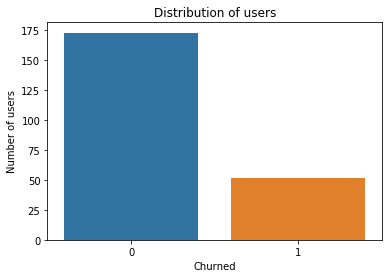

In [38]:
plt.title("Distribution of users");
ax = sns.barplot(x="churnedUserLevel", y="count",data=churn_df);
ax.set(xlabel='Churned', ylabel='Number of users')
plt.show();

**2.2.2. Level plan per churn status**

The proportion of churned users among the paid users (21.8%) is similar to the proportion of churned users among the free users (23.6%).

In [165]:
def split_per_status(df, split_variable, title, x_label, y_label):
    
    '''
    INPUT
    df - spark dataframe 
    split_variable - variable of comparison
    title - graph title
    x_label - graph x-axis label
    y_label - graph y-axis label
    
    OUTPUT
    split_df - A dataframe holding the number of customers associated with each variable of comparison, split by churn status
    '''
    
    # Calculate the number of users per split variable
    split_df = df.select(["userId","churnedUserLevel",split_variable]).dropDuplicates().groupBy([df.churnedUserLevel, df[split_variable]]).count().toPandas()
    print(split_df)
    
    # Create graph
    plt.figure(figsize=(15,8));
    plt.title(title);
    ax = sns.barplot(x="churnedUserLevel", y="count", hue=split_variable, data=split_df);
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.show();
    
    return split_df

   churnedUserLevel level  count
0                 1  paid     36
1                 1  free     46
2                 0  free    149
3                 0  paid    129


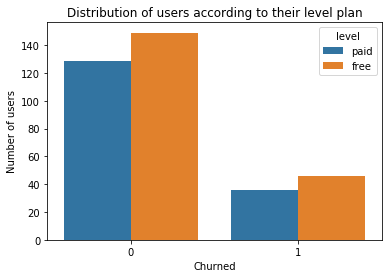

In [40]:
level_df = split_per_status(user_df, 'level', "Distribution of users according to their level plan", "Churned", 'Number of users')

**2.2.3. Gender per churn status**

There is a slightly higher proportion of male users among the churned users (61.5%) than among the active users (51.4%).

   churnedUserLevel gender  count
0                 0      F     84
1                 1      M     32
2                 1      F     20
3                 0      M     89


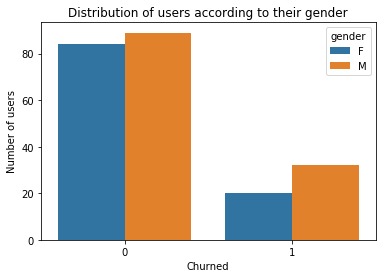

In [41]:
gender_df = split_per_status(user_df, 'gender', "Distribution of users according to their gender", "Churned", 'Number of users')

**2.2.4. Songs listened per user**

We have seen above that when a user listens to a song, it means they are logging an action on the page 'NextSong'.
The active users have listened on average to 1108 songs, while the churned users listened on average to 700 songs. We can see in the graph that among the churned users, a high number of them have listened to small numbers of songs. This is a feature we want to consider in our model.

In [42]:
def nb_page_user(df, page_name, field_name):
    
    '''
    INPUT
    df - spark dataframe 
    page_name - the page we are interested in
    field_name - the title of the column counting the visits on the specific page
    
    OUTPUT
    nb_per_user_df - the average of visits on the page, split by churned and non-churned users
    '''
    
    # Get the number of pages per user
    nb_per_user_df = df.filter(df.page == page_name).groupBy([df.userId,df.churnedUserLevel]).count().withColumnRenamed('count',field_name)
    
    # Get the mean per churn status
    nb_per_user_df.groupBy(user_df.churnedUserLevel).avg(field_name).show()
    
    return nb_per_user_df

In [43]:
songs_per_user = nb_page_user(user_df, 'NextSong', 'nb_songs')

+----------------+------------------+
|churnedUserLevel|     avg(nb_songs)|
+----------------+------------------+
|               0|1108.1734104046243|
|               1| 699.8846153846154|
+----------------+------------------+



In [44]:
# Check distributions of the nunber of songs
def distribution_graph(spark_df, label_field, split_field, title, x_label, y_label):
    
    '''
    INPUT
    spark_df - spark dataframe 
    label_field - churn label
    split_field - field of comparison
    title - graph title
    x_label - graph x-axis label
    y_label - graph y-axis label
    
    OUTPUT
    graph
    '''
    
    # Convert to pandas
    spark_df_pd = spark_df.toPandas()
    
    # Get active and churn data
    df_active = spark_df_pd[spark_df_pd[label_field] == 0][split_field]
    df_churn = spark_df_pd[spark_df_pd[label_field] == 1][split_field]
    
    # Generate graph
    plt.figure(figsize=(15,8));
    plt.title(title);
    ax1 = sns.distplot(df_churn, color="y", hist=False, label = 'Churned')
    ax2 = sns.distplot(df_active, color="r", hist=False, label = 'Active')
    ax1.set(xlabel=x_label, ylabel=y_label)
    plt.legend();

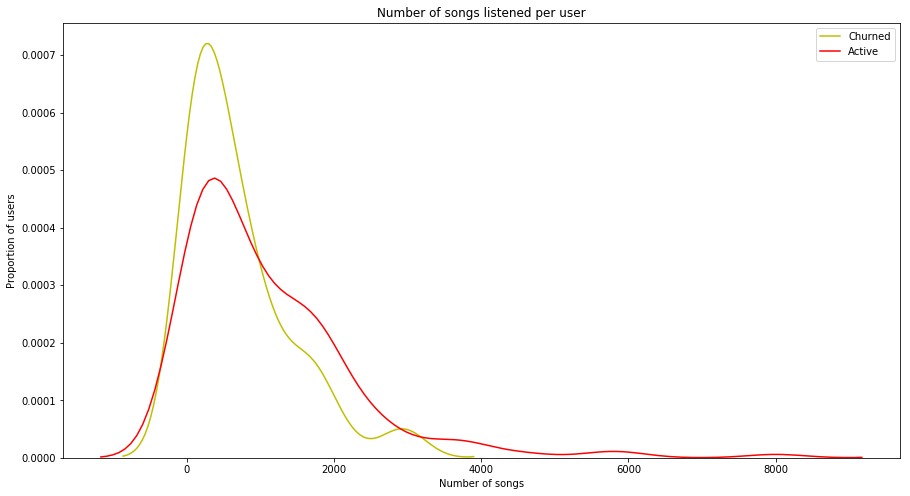

In [45]:
distribution_graph(songs_per_user, 'churnedUserLevel', 'nb_songs', "Number of songs listened per user", 'Number of songs', 'Proportion of users')

**2.2.5. Distinct number of songs listened per user**

The numbers look similar to 2.2.4, therefore the number of distinct songs does not seem to have an impact on the overall number of songs. We do want to consider this feature in our model.

In [46]:
def nb_distinct_page_user(df, page_name, distinct_field, field_name):
    
    '''
    INPUT
    df - spark dataframe 
    page_name - the page we are interested in
    distinct_field - the column to count the distinct appearences of
    field_name - the title of the column counting the visits on the specific page
    
    OUTPUT
    nb_per_user_df - the average of visits on the page, split by churned and non-churned users
    '''
    
    # Get the number of pages per user
    nb_per_user_df = df.filter(df.page == page_name).select(['userId',distinct_field,'churnedUserLevel']).dropDuplicates().groupBy([df.userId,df.churnedUserLevel]).count().withColumnRenamed('count',field_name)
    
    # Get the mean per churn status
    nb_per_user_df.groupBy(user_df.churnedUserLevel).avg(field_name).show()
    
    return nb_per_user_df

+----------------+-----------------+
|churnedUserLevel|    avg(nb_songs)|
+----------------+-----------------+
|               0|975.7687861271677|
|               1|638.3653846153846|
+----------------+-----------------+



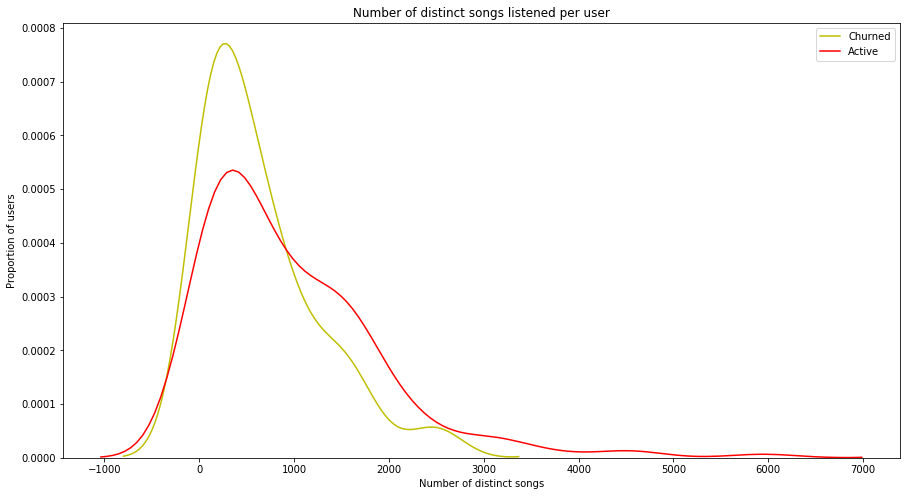

In [47]:
distinct_songs_per_user = nb_distinct_page_user(user_df, 'NextSong', 'song','nb_songs')
distribution_graph(distinct_songs_per_user, 'churnedUserLevel', 'nb_songs', "Number of distinct songs listened per user", 'Number of distinct songs', 'Proportion of users')

**2.2.6. Number of distinct sessions per user**

Churned users generated on average 10 sessions, while active users have generated on average 15 sessions. Moreover, the maximum number of sessions for churned users is around 40, while it almost reaches 120 for active customers. This is a feature we want to consider for our model.

In [48]:
def nb_distinct_user(df, distinct_field, field_name):
    
    '''
    INPUT
    df - spark dataframe 
    distinct_field - the column to count the distinct appearences of
    field_name - the title of the column counting the visits on the specific page
    
    OUTPUT
    nb_per_user_df - the average number of appearences, split by churned and non-churned users
    '''
    
    # Get the number of items per user
    nb_per_user_df = df.select(['userId',distinct_field,'churnedUserLevel']).dropDuplicates().groupBy([df.userId,df.churnedUserLevel]).count().withColumnRenamed('count',field_name)
    
    # Get the mean per churn status
    nb_per_user_df.groupBy(user_df.churnedUserLevel).avg(field_name).show()
    
    return nb_per_user_df

+----------------+------------------+
|churnedUserLevel|  avg(nb_sessions)|
+----------------+------------------+
|               0|15.254335260115607|
|               1|10.326923076923077|
+----------------+------------------+



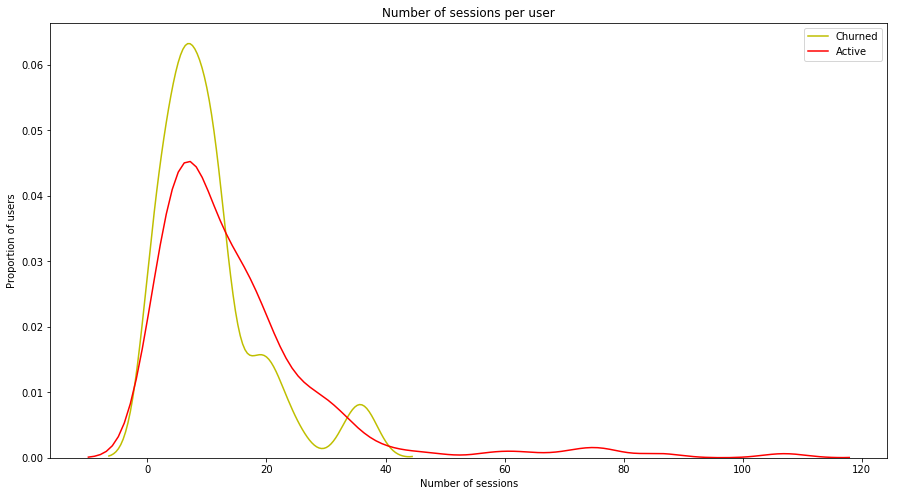

In [49]:
sessions_per_user = nb_distinct_user(user_df, 'sessionId','nb_sessions')
distribution_graph(sessions_per_user, 'churnedUserLevel', 'nb_sessions', "Number of sessions per user", 'Number of sessions', 'Proportion of users')

**2.2.7. Number of distinct artists per user**

We can see that on average active customers listen to a higher number of different artists than churned users.

+----------------+-----------------+
|churnedUserLevel|  avg(nb_artists)|
+----------------+-----------------+
|               0|750.7803468208092|
|               1|519.6923076923077|
+----------------+-----------------+



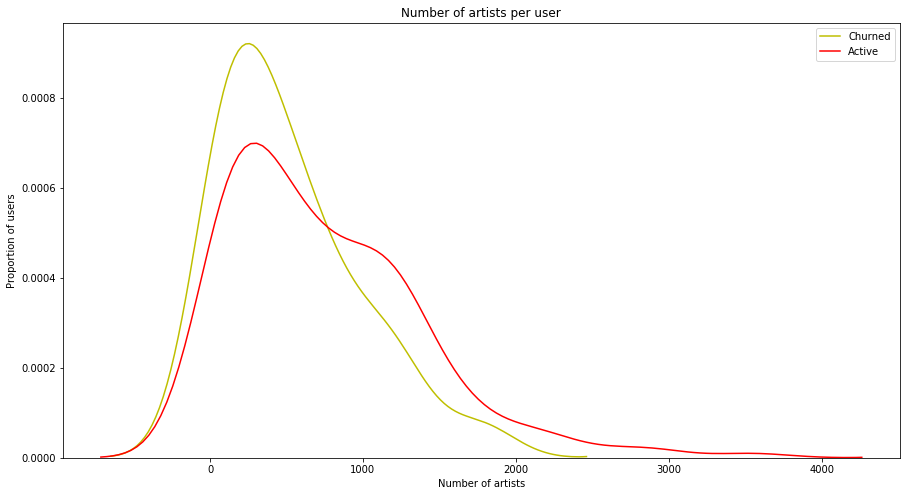

In [125]:
artists_per_user = nb_distinct_user(user_df, 'artist','nb_artists')
distribution_graph(artists_per_user, 'churnedUserLevel', 'nb_artists', "Number of artists per user", 'Number of artists', 'Proportion of users')

**2.2.8. Number of errors encountered per user**

Active customers encountered on average 2.3 errors, while churned customers encountered on average 1.45 errors. It looks like then that the active customers encountered more often errors, but it might also be linked to the fact that they also have more sessions than the churned customers on the platform. Therefore, this is not likely we will consider this feature for our model.

+----------------+------------------+
|churnedUserLevel|    avg(nb_errors)|
+----------------+------------------+
|               0|2.3157894736842106|
|               1|1.4545454545454546|
+----------------+------------------+



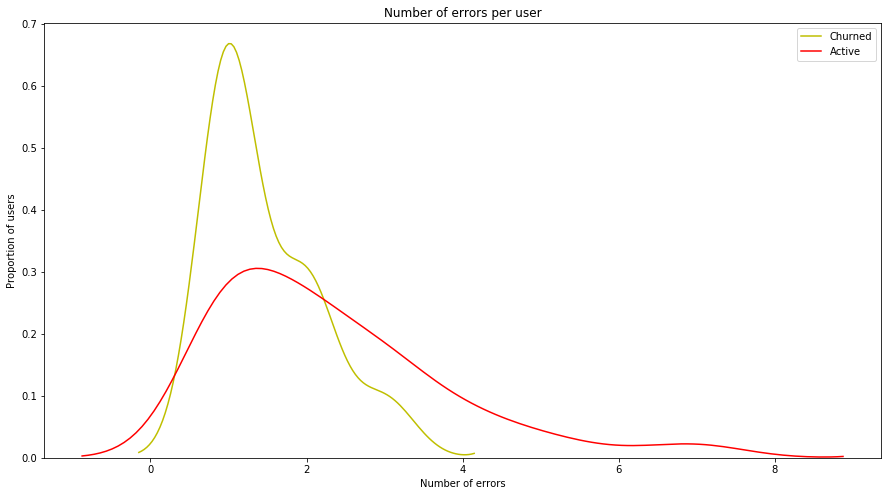

In [50]:
errors_per_user = nb_page_user(user_df, 'Error', 'nb_errors')
distribution_graph(errors_per_user, 'churnedUserLevel', 'nb_errors', "Number of errors per user", 'Number of errors', 'Proportion of users')

**2.2.9. Average number of songs listened per user per day**

Active and churned customers listen to approximately the same number of songs per day, on average.

In [51]:
# Get the number of songs per user per day
song_per_day_per_user = user_df.filter(user_df.page == 'NextSong').groupBy([user_df.userId, user_df.churnedUserLevel, user_df.log_date]).count().withColumnRenamed('count','nb_songs')

# Get the average number of songs a day per user
avg_song_per_day = song_per_day_per_user.groupBy([song_per_day_per_user.userId, song_per_day_per_user.churnedUserLevel]).avg('nb_songs').withColumnRenamed('avg(nb_songs)','avg_songs')

+----------------+-----------------+
|churnedUserLevel|   avg(avg_songs)|
+----------------+-----------------+
|               0|64.98898351495575|
|               1|62.53653785936774|
+----------------+-----------------+



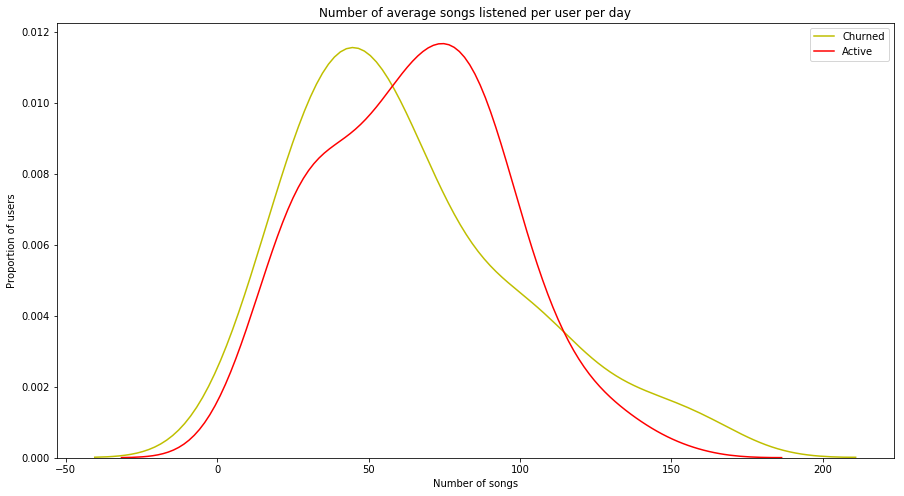

In [52]:
avg_song_per_day.groupBy([avg_song_per_day.churnedUserLevel]).avg('avg_songs').withColumnRenamed("avg('avg_songs')",'avg_avg_songs').show()
distribution_graph(avg_song_per_day, 'churnedUserLevel', 'avg_songs', "Number of average songs listened per user per day", 'Number of songs', 'Proportion of users')

**2.2.10. Average number of sessions per day**

The churned users have a higher number of sessions a day than the active customers.

In [129]:
# Get the number of sessions per user per day
nb_sessions_per_user = user_df.select(['userId','sessionId','churnedUserLevel','log_date']).dropDuplicates().groupBy([user_df.userId,user_df.churnedUserLevel, user_df.log_date]).count().withColumnRenamed('count',('nb_sessions'))

# Get the average number of sessions a day per user
avg_sessions_per_day = nb_sessions_per_user.groupBy([nb_sessions_per_user.userId, nb_sessions_per_user.churnedUserLevel]).avg('nb_sessions').withColumnRenamed('avg(nb_sessions)','avg_sessions')

+----------------+------------------+
|churnedUserLevel| avg(avg_sessions)|
+----------------+------------------+
|               0| 1.113367203105285|
|               1|1.2014248403288454|
+----------------+------------------+



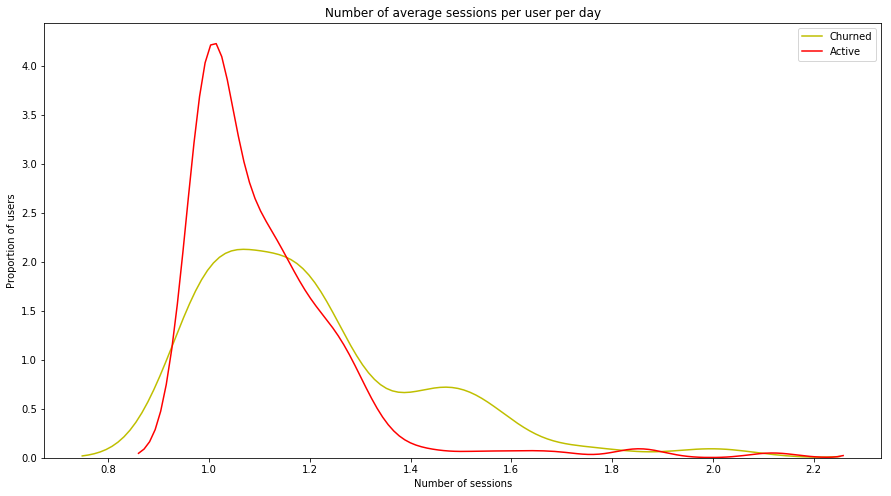

In [130]:
avg_sessions_per_day.groupBy([avg_sessions_per_day.churnedUserLevel]).avg('avg_sessions').withColumnRenamed("avg('avg_sessions')",'avg_sessions').show()
distribution_graph(avg_sessions_per_day, 'churnedUserLevel', 'avg_sessions', "Number of average sessions per user per day", 'Number of sessions', 'Proportion of users')

**2.2.11. Number of visits on the help page per user**

Active users visited on average the help page 8 times, while churned users visited it 5 times. This makes me think that visiting the help page could have a positive effect on the customers. This is a feature we want to look into for our model.

+----------------+-----------------+
|churnedUserLevel|     avg(nb_help)|
+----------------+-----------------+
|               0|8.154362416107382|
|               1|5.558139534883721|
+----------------+-----------------+



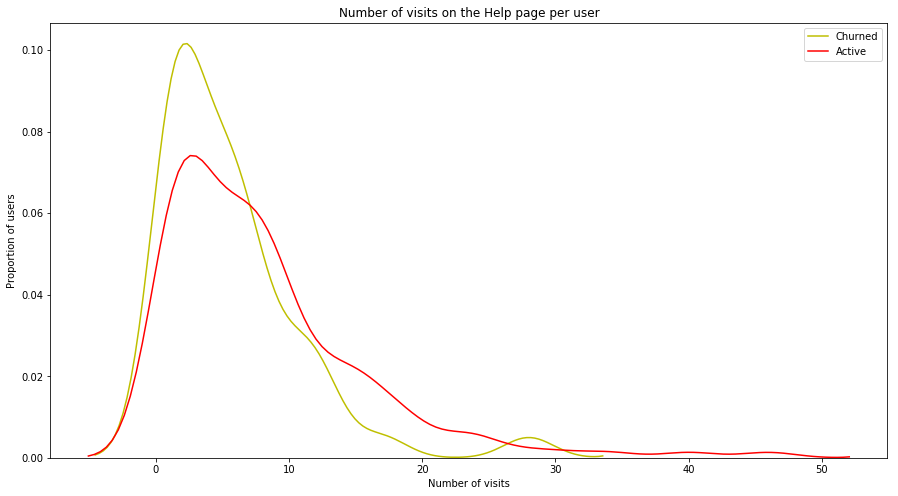

In [53]:
helps_per_user = nb_page_user(user_df, 'Help', 'nb_help')
distribution_graph(helps_per_user, 'churnedUserLevel', 'nb_help', "Number of visits on the Help page per user", 'Number of visits', 'Proportion of users')

**2.2.12. Number of times the user gave thumbs up**

The active customers gave almost twice as much thumbs up as the churned customers. This is a feature we want to keep.

+----------------+-----------------+
|churnedUserLevel|avg(nb_thumbs_up)|
+----------------+-----------------+
|               0|62.89411764705882|
|               1|            37.18|
+----------------+-----------------+



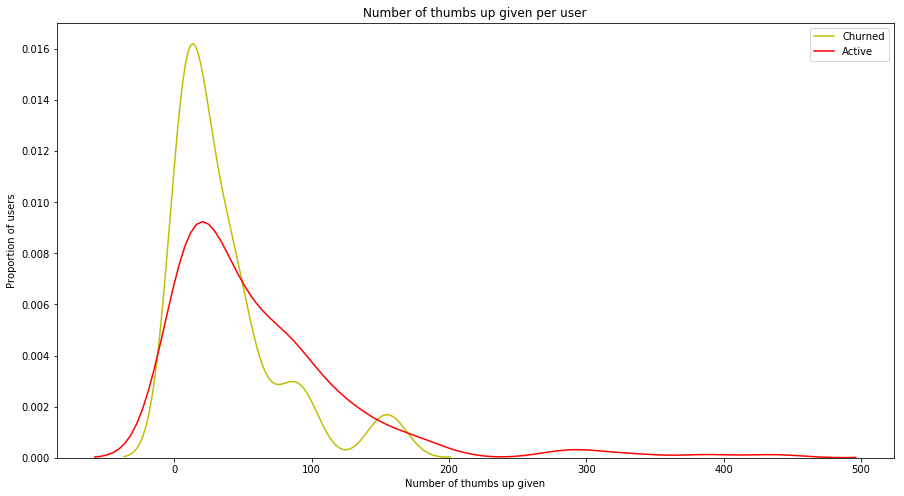

In [54]:
thumbs_up_per_user = nb_page_user(user_df, 'Thumbs Up', 'nb_thumbs_up')
distribution_graph(thumbs_up_per_user, 'churnedUserLevel', 'nb_thumbs_up', "Number of thumbs up given per user", 'Number of thumbs up given', 'Proportion of users')

**2.2.13. Number of times the user gave thumbs down**

The number of times churned and active customers have given thumbs down is very similar. This is a feature we do no think will help us predict churn.

+----------------+-------------------+
|churnedUserLevel|avg(nb_thumbs_down)|
+----------------+-------------------+
|               0| 13.225806451612904|
|               1| 10.333333333333334|
+----------------+-------------------+



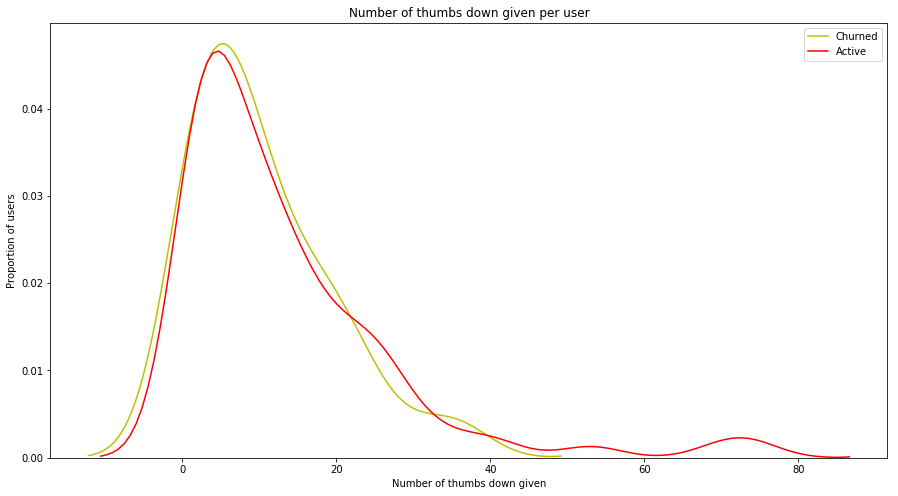

In [55]:
thumbs_down_per_user = nb_page_user(user_df, 'Thumbs Down', 'nb_thumbs_down')
distribution_graph(thumbs_down_per_user, 'churnedUserLevel', 'nb_thumbs_down', "Number of thumbs down given per user", 'Number of thumbs down given', 'Proportion of users')

**2.2.14. Number of visits on the settings page per user**

On average, active users visit the settings page more often than the churned ones. However, in practice, I do not manage to imagine what it could mean. We want to keep this feature for the model.

+----------------+----------------+
|churnedUserLevel|avg(nb_settings)|
+----------------+----------------+
|               0|8.18421052631579|
|               1|6.27906976744186|
+----------------+----------------+



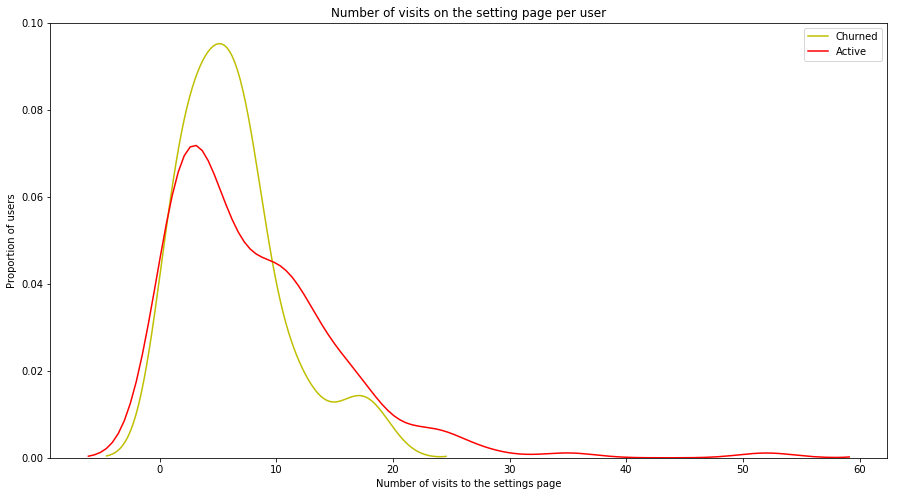

In [56]:
settings_per_user = nb_page_user(user_df, 'Settings', 'nb_settings')
distribution_graph(settings_per_user, 'churnedUserLevel', 'nb_settings', "Number of visits on the setting page per user", 'Number of visits to the settings page', 'Proportion of users')

**2.2.15. Number of friends added per user**

We can see that on average, active customers have added 22 friends to the platform, while churned customers added on average 14 friends. 

+----------------+------------------+
|churnedUserLevel|    avg(nb_friend)|
+----------------+------------------+
|               0| 22.47530864197531|
|               1|14.454545454545455|
+----------------+------------------+



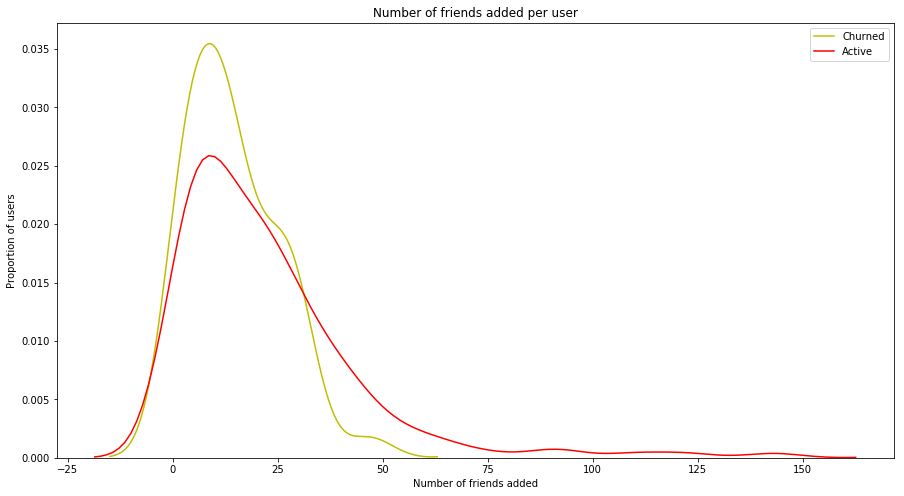

In [57]:
friends_per_user = nb_page_user(user_df, 'Add Friend', 'nb_friend')
distribution_graph(friends_per_user, 'churnedUserLevel', 'nb_friend', "Number of friends added per user", 'Number of friends added', 'Proportion of users')

**2.2.16. Number of songs added to a playlist per user**

We can see that on average, active customers have added 33 songs to a playlist, while churned customers added on average 21 songs to a playlist. 

+----------------+-----------------+
|churnedUserLevel| avg(nb_playlist)|
+----------------+-----------------+
|               0|33.26060606060606|
|               1|            20.76|
+----------------+-----------------+



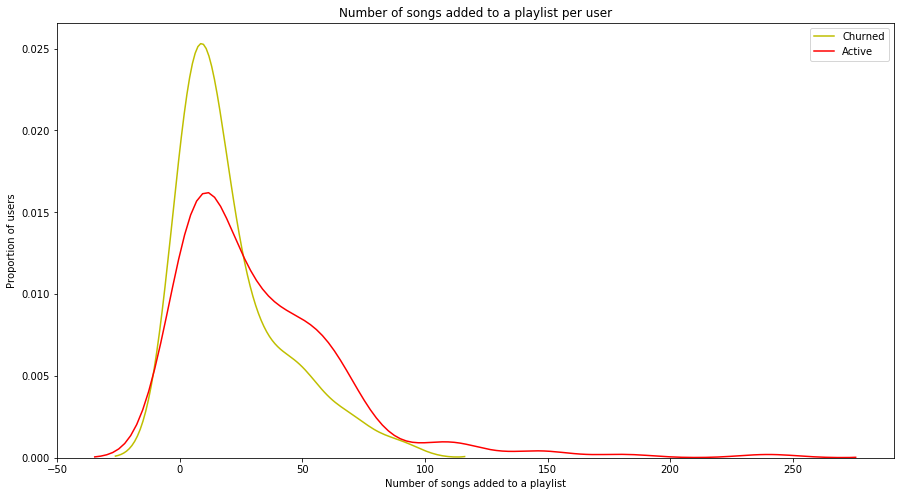

In [58]:
playlist_per_user = nb_page_user(user_df, 'Add to Playlist', 'nb_playlist')
distribution_graph(playlist_per_user, 'churnedUserLevel', 'nb_playlist', "Number of songs added to a playlist per user", 'Number of songs added to a playlist', 'Proportion of users')

**2.2.17. Number of days of activity on the platform per user**

Active customers spent on average 5 days more than churned customers on the platform.

+----------------+------------------+
|churnedUserLevel|      avg(nb_days)|
+----------------+------------------+
|               0|15.104046242774567|
|               1| 9.826923076923077|
+----------------+------------------+



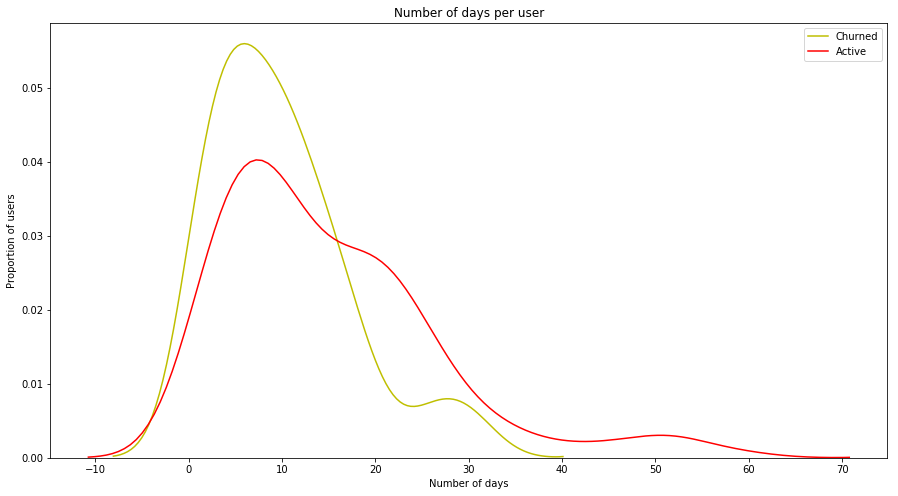

In [59]:
days_per_user = nb_distinct_user(user_df, 'log_date','nb_days')
distribution_graph(days_per_user, 'churnedUserLevel', 'nb_days', "Number of days per user", 'Number of days', 'Proportion of users')

**2.2.18. Churn status per user agent**

The majority of the users use Windows or Macintosh. We see a few qctive users using the iPad, but no churned users were using an iPad. 

In [60]:
# Add platform column to the dataframe
first_parant = udf(lambda x: re.search(r'\(([^)]+)\)', x).group(1))
first_word = udf(lambda x: x.split()[0])

user_df = user_df.withColumn("platform_temp", first_parant(user_df.userAgent))
user_df = user_df.withColumn("platform_raw", first_word(user_df.platform_temp))
user_df = user_df.withColumn('platform', regexp_replace('platform_raw', ';', ''))

In [61]:
user_df.select(['platform']).dropDuplicates().show()

+----------+
|  platform|
+----------+
|      iPad|
|       X11|
|    iPhone|
| Macintosh|
|compatible|
|   Windows|
+----------+



   churnedUserLevel    platform  count
0                 0      iPhone      9
1                 0     Windows     82
2                 1         X11      5
3                 1      iPhone      4
4                 1     Windows     24
5                 0         X11      7
6                 0   Macintosh     67
7                 0  compatible      5
8                 1   Macintosh     19
9                 0        iPad      3


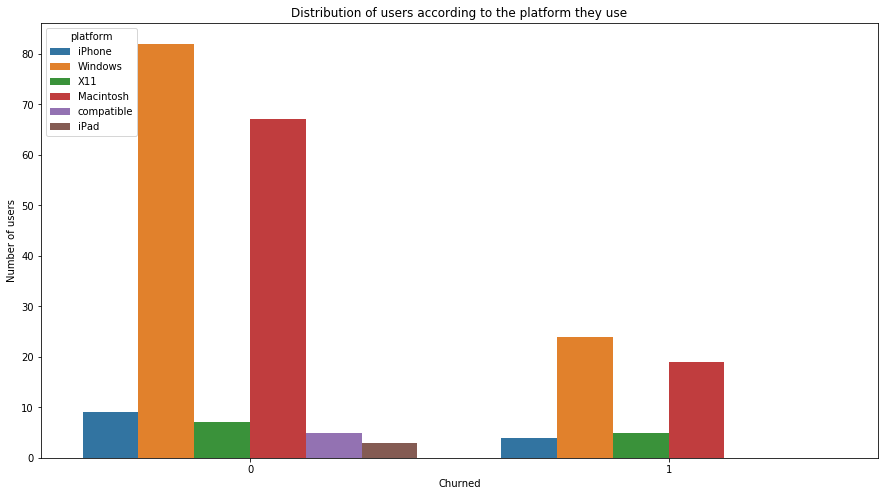

In [166]:
platform_df = split_per_status(user_df, 'platform', "Distribution of users according to the platform they use", "Churned", 'Number of users')

# 3. Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**3.1. Review the initial dataset**

In [98]:
user_df.show(5)

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+--------------------+------------+--------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|       log_datetime|  log_date|churned|churnedUserLevel|       platform_temp|platform_raw|platform|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+----------+-------+----------------+--------------------+------------+--------+
|Sleeping With Sirens|Logged In| Dari

We want to create a dataset with one row per user.

**3.2. Create final dataset**

In [99]:
user_level_df= user_df.select(['userId','churnedUserLevel']).dropDuplicates().toPandas()
user_level_df.head()

,userId,churnedUserLevel
0,100010,0
1,200002,0
2,125,1
3,124,0
4,51,1


**3.3. Create binary columns**

In [100]:
# Create function to create binary columns, based on their value
def integer_column(df, column, value, new_column_name, final_df):
    
    '''
    INPUT
    df - spark dataframe 
    column - the initial column to use as base to create the new column
    value - the value the initial column must have
    new_column_name - the name of the new column
    final_df - the dataframe to which append the newly created columns
    
    OUTPUT
    final_df - the initial dataframe with the new column appended
    '''
    
    # Create function
    new_col_fct = udf(lambda x: 1 if x == value else 0, IntegerType())
    
    # Create new column
    df = df.withColumn(new_column_name, new_col_fct(df[column]))
    df_group = df.groupBy(df.userId).max(new_column_name).toPandas()
    df_group.columns = ['userId',new_column_name]
    
    # Merge with final dataset
    final_df = pd.merge(final_df, df_group, on='userId', how='left')
    
    return final_df

In [101]:
# Create binary columns

# Plan type
user_level_df = integer_column(user_df, 'level', 'free', 'freePlan', user_level_df)
user_level_df = integer_column(user_df, 'level', 'paid', 'paidPlan', user_level_df)

# Gender
user_level_df = integer_column(user_df, 'gender', 'M', 'genderM', user_level_df)
user_level_df = integer_column(user_df, 'gender', 'F', 'genderF', user_level_df)

# Platform
platform_items = list(user_df.select(['platform']).dropDuplicates().toPandas()['platform'])

for platform in platform_items:
    user_level_df = integer_column(user_df, 'platform', platform, platform, user_level_df)

**3.4. Create page-related columns**

In [102]:
# Create function for the number of visits per page columns
def nb_page_visits_column(df, column, page_value, new_column_name, final_df):
    
    '''
    INPUT
    df - spark dataframe 
    column - the initial column to use as base to create the new column
    page_value - the value the page column must have
    new_column_name - the name of the new column
    final_df - the dataframe to which append the newly created columns
    
    OUTPUT
    final_df - the initial dataframe with the new column appended
    '''
    
    # Create new column
    df_page = df.filter(user_df[column] == page_value).groupBy(user_df.userId).count().withColumnRenamed('count',new_column_name).toPandas()
    
    # Merge with final dataset
    final_df = pd.merge(final_df, df_page, on='userId', how='left') 
    
    return final_df

In [103]:
# Get the different pages a user can go to
list(user_df.select(['page']).dropDuplicates().toPandas()['page'])

['Cancel',
 'Submit Downgrade',
 'Thumbs Down',
 'Home',
 'Downgrade',
 'Roll Advert',
 'Logout',
 'Save Settings',
 'Cancellation Confirmation',
 'About',
 'Settings',
 'Add to Playlist',
 'Add Friend',
 'NextSong',
 'Thumbs Up',
 'Help',
 'Upgrade',
 'Error',
 'Submit Upgrade']

In [104]:
# Create a list with the pages visit we want to create columns with
page_visits_colums = ['Submit Downgrade', 'Thumbs Down', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Error', 'Submit Upgrade', 'Roll Advert',]

In [105]:
# Create the columns
for page_col in page_visits_colums:
    user_level_df = nb_page_visits_column(user_df, 'page', page_col, page_col, user_level_df)

**3.5. Get distinct number of sessions, days and artists**

In [106]:
# Create function for the number of distinct sessions and days on the platform
def nb_distinct_value_col(df, column, new_column_name, final_df):
    
    '''
    INPUT
    df - spark dataframe 
    column - the initial column to use as base to create the new column
    new_column_name - the name of the new column
    final_df - the dataframe to which append the newly created columns
    
    OUTPUT
    final_df - the initial dataframe with the new column appended
    '''
    
    # Create new column
    df_distinct = df.select(['userId',column]).dropDuplicates().groupBy([df.userId]).count().withColumnRenamed('count',new_column_name).toPandas()
    
    # Merge with final dataset
    final_df = pd.merge(final_df, df_distinct, on='userId', how='left') 
    
    return final_df

In [107]:
# Create the columns

# Number of sessions
user_level_df = nb_distinct_value_col(user_df, 'sessionId', 'numberSessions', user_level_df)

# Number of days
user_level_df = nb_distinct_value_col(user_df, 'log_date', 'numberDays', user_level_df)

# Number of artists
user_level_df = nb_distinct_value_col(user_df, 'artist', 'numberArtists', user_level_df)

**3.6. Get average number of songs listened per day**

In [108]:
# Get the number of songs for each userId and each day
song_per_day = user_df.filter(user_df.page == 'NextSong').groupBy([user_df.userId, user_df.log_date]).count().withColumnRenamed('count','nb_songs')

# Get the average number of songs per day per user
avg_song_per_day = song_per_day.groupBy([song_per_day.userId]).avg('nb_songs').withColumnRenamed('avg(nb_songs)','avgSongsPerDay').toPandas()

# Add column to the final dataset
user_level_df = pd.merge(user_level_df, avg_song_per_day, on='userId', how='left') 

**3.7. Get average number of sessions per day**

In [135]:
# Get the number of sessions per user per day
sessions_per_day = user_df.select(['userId','sessionId','churnedUserLevel','log_date']).dropDuplicates().groupBy([user_df.userId,user_df.churnedUserLevel, user_df.log_date]).count().withColumnRenamed('count',('nb_sessions'))

# Get the average number of sessions a day per user
avg_sessions_per_day = nb_sessions_per_user.groupBy([nb_sessions_per_user.userId]).avg('nb_sessions').withColumnRenamed('avg(nb_sessions)','avgSessionsPerDay').toPandas()

# Add column to the final dataset
user_level_df = pd.merge(user_level_df, avg_sessions_per_day, on='userId', how='left') 

**3.8. Get final dataset for modelling**

In [136]:
# Get final result
user_level_df.head()

,userId,churned,freePlan,paidPlan,genderM,iPad,X11,usedIPhone,usedMacintosh,usedCompatible,...,numberThumbsUpGiven,numberHelpVisits,numberErrors,numberUpgrades,numberAds,numberSessions,numberDays,numberArtists,avgSongsPerDay,avgSessionsPerDay
0,100010,0,1,0,0,0,0,1,0,0,...,17.0,2.0,0.0,0.0,52.0,7,7,253,39.285714,1.000000
1,200002,0,1,1,1,0,0,1,0,0,...,21.0,2.0,0.0,1.0,7.0,6,7,340,55.285714,1.000000
2,125,1,1,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,1,1,9,8.000000,1.000000
3,124,0,0,1,0,0,0,0,1,0,...,171.0,23.0,6.0,0.0,4.0,29,33,2233,127.468750,1.242424
4,51,1,0,1,1,0,0,0,0,0,...,100.0,12.0,1.0,0.0,0.0,10,13,1386,162.384615,1.230769


In [137]:
# Get column names
list(user_level_df.columns)

['userId',
 'churned',
 'freePlan',
 'paidPlan',
 'genderM',
 'iPad',
 'X11',
 'usedIPhone',
 'usedMacintosh',
 'usedCompatible',
 'usedWindows',
 'numberDowngrades',
 'numberThumbsDownGiven',
 'numberSettingsVisits',
 'numberSongsToPlaylist',
 'numberFriendsAdded',
 'numberSongsListened',
 'numberThumbsUpGiven',
 'numberHelpVisits',
 'numberErrors',
 'numberUpgrades',
 'numberAds',
 'numberSessions',
 'numberDays',
 'numberArtists',
 'avgSongsPerDay',
 'avgSessionsPerDay']

In [138]:
# Rename columns
user_level_df.columns = ['userId', 'churned', 'freePlan', 'paidPlan', 'genderM', 'genderF', 'iPad', 'X11', 'usedIPhone', 'usedMacintosh', 'usedCompatible', 'usedWindows', 'numberDowngrades', 'numberThumbsDownGiven', 'numberSettingsVisits',
                         'numberSongsToPlaylist', 'numberFriendsAdded', 'numberSongsListened', 'numberThumbsUpGiven', 'numberHelpVisits', 'numberErrors', 'numberUpgrades', 'numberAds', 'numberSessions','numberDays', 'numberArtists',
                         'avgSongsPerDay','avgSessionsPerDay']

ValueError: Length mismatch: Expected axis has 27 elements, new values have 28 elements

In [139]:
# See final result
user_level_df.head()

,userId,churned,freePlan,paidPlan,genderM,iPad,X11,usedIPhone,usedMacintosh,usedCompatible,...,numberThumbsUpGiven,numberHelpVisits,numberErrors,numberUpgrades,numberAds,numberSessions,numberDays,numberArtists,avgSongsPerDay,avgSessionsPerDay
0,100010,0,1,0,0,0,0,1,0,0,...,17.0,2.0,0.0,0.0,52.0,7,7,253,39.285714,1.000000
1,200002,0,1,1,1,0,0,1,0,0,...,21.0,2.0,0.0,1.0,7.0,6,7,340,55.285714,1.000000
2,125,1,1,0,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,1.0,1,1,9,8.000000,1.000000
3,124,0,0,1,0,0,0,0,1,0,...,171.0,23.0,6.0,0.0,4.0,29,33,2233,127.468750,1.242424
4,51,1,0,1,1,0,0,0,0,0,...,100.0,12.0,1.0,0.0,0.0,10,13,1386,162.384615,1.230769


Check the columns with missing values.

In [140]:
def missing_values(data):
    
    '''
    INPUT
    data - pandas dataframe 
    
    OUTPUT
    missing_val_df - A dataframe holding the fields with missing values and the proportion of them
    '''

    missing_values = pd.DataFrame((len(data)-data.count())/len(data)*100).reset_index()
    missing_values.columns = ['field', 'percentageNulls']
    missing_val_df = missing_values[missing_values['percentageNulls']>0].sort_values('percentageNulls',ascending=False)
    
    return missing_val_df

missing_values(user_level_df)

,field,percentageNulls


We see that the missing values are all related to pages where the user did not go on. We can replace them all with zeros.

In [114]:
user_level_df = user_level_df.fillna(0)

In [115]:
missing_values(user_level_df)

,field,percentageNulls


# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**4.1. Identify if features are correlated with each other**

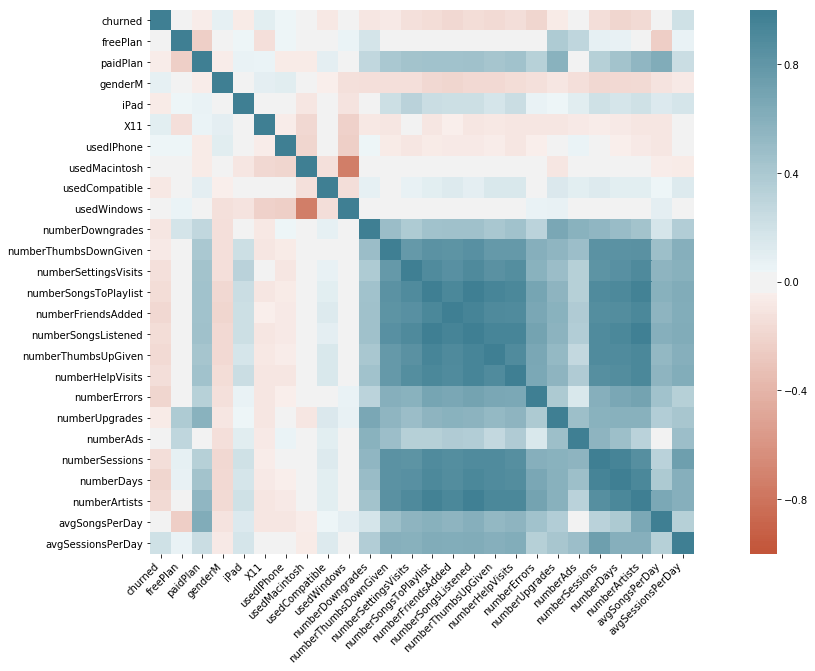

In [141]:
def correlation_heatmap(df):
    
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    correlation heatmap
    '''

    # Get correlations
    corr = df.corr()
    
    # Get figure size
    plt.figure(figsize=(20,10));

    # Create heatmap
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )

    # Add labels
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
    
correlation_heatmap(user_level_df)

We can identify some features correlated. For example:
1. The gender columns are negatively correlated with each other. This makes sense since you can only be either of the two. Therefore, just keeping one of them is enough.
2. Windows and Macintosh are negatively correlated with each other. This is because they are the 2 main platforms where people stream music. However, since there are other platforms in the mix, we keep the two columns.
3. We can see that the page visits-related columns are correlated with each other. This is because someone who is going to be active more frequently will tend to have clicked on a higher number of pages too.
4. The number of sessions and number of days spent on the platform are highly correlated with each other. We will then drop the number of sessions as we have the number of sessions per day.
5. We observed in the analysis that the number of thumbs given for both active and churned customers was similar. We will remove this feature from our model.

We will leave the rest as it is. Find below the changes to the dataset.

In [148]:
# Drop female gender column
user_level_df = user_level_df.drop('genderF', axis = 1)

# Drop number of sessions
user_level_df = user_level_df.drop('numberSessions', axis = 1)

# Drop number of thumbs down
user_level_df = user_level_df.drop('numberThumbsDownGiven', axis = 1)

# # Create percentage of songs added to playlist
# user_level_df['percentageSongsToPlaylist'] = user_level_df['numberSongsToPlaylist'] / user_level_df['numberSongsListened']
# user_level_df = user_level_df.drop('numberSongsToPlaylist', axis = 1)

# # Create percentage of songs given thumbs down
# user_level_df['percentageThumbsDownGiven'] = user_level_df['numberThumbsDownGiven'] / user_level_df['numberSongsListened']
# user_level_df = user_level_df.drop('numberThumbsDownGiven', axis = 1)

# # Create percentage of songs given thumbs up
# user_level_df['percentageThumbsUpGiven'] = user_level_df['numberThumbsUpGiven'] / user_level_df['numberSongsListened']
# user_level_df = user_level_df.drop('numberThumbsUpGiven', axis = 1)

user_level_df.head()

,userId,churned,freePlan,paidPlan,genderM,iPad,X11,usedIPhone,usedMacintosh,usedCompatible,...,numberSongsListened,numberThumbsUpGiven,numberHelpVisits,numberErrors,numberUpgrades,numberAds,numberDays,numberArtists,avgSongsPerDay,avgSessionsPerDay
0,100010,0,1,0,0,0,0,1,0,0,...,275,17.0,2.0,0.0,0.0,52.0,7,253,39.285714,1.000000
1,200002,0,1,1,1,0,0,1,0,0,...,387,21.0,2.0,0.0,1.0,7.0,7,340,55.285714,1.000000
2,125,1,1,0,1,0,0,0,1,0,...,8,0.0,0.0,0.0,0.0,1.0,1,9,8.000000,1.000000
3,124,0,0,1,0,0,0,0,1,0,...,4079,171.0,23.0,6.0,0.0,4.0,33,2233,127.468750,1.242424
4,51,1,0,1,1,0,0,0,0,0,...,2111,100.0,12.0,1.0,0.0,0.0,13,1386,162.384615,1.230769


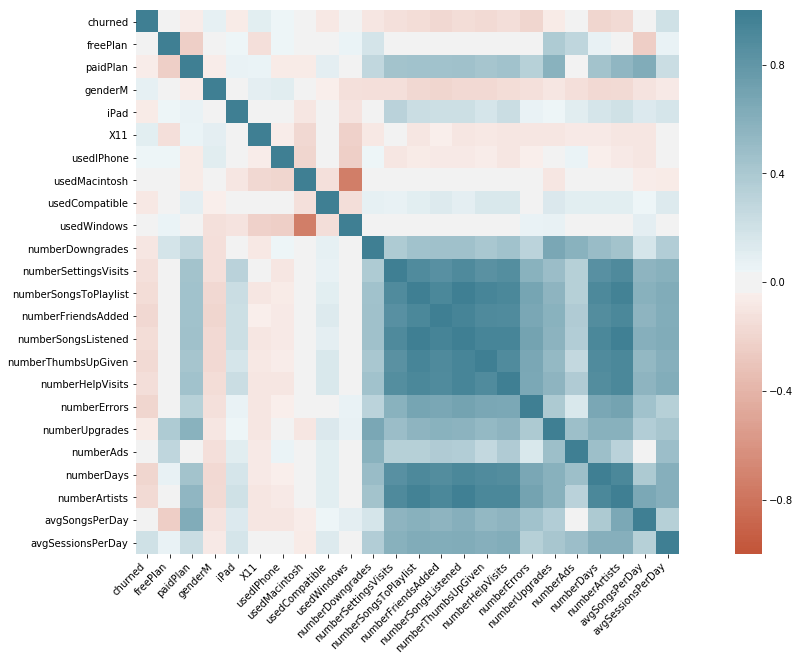

In [149]:
# Check the correlation heatmap again
correlation_heatmap(user_level_df)

We have now reduced the correlation between variables. Let's normalize our data and start modelling.

**4.2. Prepare data**

In [167]:
test = user_level_df.drop(['userId'], axis=1)

In [150]:
def prepare_data(df, independent_var, test_size, random_state):
    
    '''
    INPUT
    df - pandas dataframe 
    independent_var - the independent variable to predict
    test_size - the percentage of data in the test (in decimal)
    random_state - the random state to keep the same results

    OUTPUT
    X_train, X_test, y_train, y_test - X and y datasets split into train and test
    '''
    
    # Get X and y
    X = df.drop(independent_var,axis=1)
    y = df[independent_var]
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state) 
    
    return X_train, X_test, y_train, y_test

In [168]:
X_train, X_test, y_train, y_test = prepare_data(test, 'churned', 0.3, 42)

**4.3. Model data**

In [174]:
def model_data(scaler, ml_model, params):
    
    '''
    INPUT
    scaler - the scaler to use to normalize the data
    ml_model - the machine learning classifier to use
    params - the parameters on which to run grid search to optimize on F1 score

    OUTPUT
    the model and its score
    '''

    # Create pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', ml_model)
    ])
    
    # Grid search
    cv = GridSearchCV(pipeline, param_grid=params, error_score=0.0, scoring='f1') # error_score ignore forbidden combinations
    
    # Train classifier
    cv.fit(X_train, y_train)
    
    # Predict on test data
    y_train_pred = cv.predict(X_train)
    y_test_pred = cv.predict(X_test)
    
    # Score using your model
    test_score = f1_score(y_test, y_test_pred)
    train_score = f1_score(y_train, y_train_pred)
    
    print('\nTrain F1 score: '+str(train_score*100)+'%')
    print('Test F1 score: '+str(test_score*100)+'%')
    print("\nBest Parameters:", cv.best_params_)

In [175]:
scaler = StandardScaler()
model = RandomForestClassifier(max_depth=2, random_state=0)
parameters = {
        'model__max_depth': (1,2,3,4,5,6,7,8,9),
        'model__min_samples_leaf': (1,2,3,4,5,6,7,8,9),
        'model__n_jobs': (1,2)
    }

model_data(scaler, model, parameters)


Train F1 score: 94.1176470588%
Test F1 score: 26.0869565217%

Best Parameters: {'model__max_depth': 9, 'model__min_samples_leaf': 1, 'model__n_jobs': 1}


In [176]:
scaler = StandardScaler()
model = LogisticRegression(random_state=0)
parameters = {
        'model__C': (1,2,3,4,5,6),
        'model__solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),
        'model__penalty': ('l1', 'l2', 'elasticnet', 'none'),
        'model__class_weight': (None, 'balanced')
        #'model__dual': (True, False),
        #'model__fit_intercept': (True, False),
       # 'model__intercept_scaling': (1,2,3,4)
    }

model_data(scaler, model, parameters)


Train F1 score: 71.2643678161%
Test F1 score: 29.4117647059%

Best Parameters: {'model__C': 4, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'liblinear'}


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.